In [1]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math


import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests


import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from scipy import stats
from scipy.stats import f_oneway

c:\Users\Wyss User\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


2023-11-28 18:02:26,053 | INFO : Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-11-28 18:02:26,054 | INFO : NumExpr defaulting to 8 threads.


In [2]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta.fasta"
ASSAY_LIST_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\assay-list-olink-explore-3072.xlsx"
)
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
MICROGLIA_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\microglia_fasta.fasta"
)
MANIFEST_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Shah (BWH)_OLINK_SK-5T4V_2023-06-27_MN UPDATES 82823.xlsx"
PLATE_LAYOUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Plate Layout.xlsx"


RAW_DATA_FILE = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"


PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]


UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",

    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]



X_AXIS_ORDER = [
    "Fract 6",
    "Fract 7",
    "Fract 8",
    "Fract 9",
    "Fract 10",
    "Fract 11",
    "Fract 12",
    "Fract 13",
    "Fract 14",
    "Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
    "Plas A Internal EV",
    "Plas B Internal EV",
    "Plas C Internal EV",
    "Plasma D Internal EV",
]

In [3]:
# clean up the raw olink data file and map the sample locations to their barcodes

plate_layout = pd.read_excel(PLATE_LAYOUT_PATH)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
manifest = pd.read_excel(MANIFEST_PATH)

raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

sample_location_dict = dict(zip(manifest.SampleID, manifest.Broad_Sample_ID))
raw_data["Location"] = raw_data["SampleID"].map(sample_location_dict)

layout_dict = dict(zip(plate_layout.Location, plate_layout.Sample))
layout_dict2 = dict(zip(plate_layout.Location, plate_layout.Additional_info))
layout_dict3 = dict(zip(plate_layout.Location, plate_layout.CSF_sample))

raw_data["Sample Description"] = raw_data["Location"].map(layout_dict)
raw_data["Additional Information"] = raw_data["Location"].map(layout_dict2)
raw_data["Sample Number"] = raw_data["Location"].map(layout_dict3)


def make_linear(x):
    return 2**x


raw_data["Linear NPX"] = raw_data["NPX"].map(make_linear)

In [4]:
# normalize each panel according to the plate controls
normalized_data = pd.DataFrame()

for panel in PANELS:
    df = raw_data[raw_data["Panel"] == panel]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["Linear NPX"].median()
    df["Delta"] = df["Linear NPX"].apply(lambda x: x - plate_ctrl)
    inc_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL") & (df["Assay"] == "Incubation control 1")
    ]["Delta"].median()
    df["Delta Delta"] = df["Delta"].apply(lambda x: x - inc_ctrl)
    normalized_data = pd.concat([normalized_data, df], ignore_index=True)

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_26356\1410252490.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Delta"] = df["Linear NPX"].apply(lambda x: x - plate_ctrl)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_26356\1410252490.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Delta Delta"] = df["Delta"].apply(lambda x: x - inc_ctrl)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_26356\1410252490.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [5]:
# anova test to determine significance of differences between healthy, mild cognitive impairment, and AD samples
assay_list = pd.read_excel(ASSAY_LIST_PATH)

anova_test = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

for assay in assay_list["UniProt ID"]:
    assay_df = normalized_data[normalized_data["UniProt"] == assay]
    healthy_df = assay_df[
        (assay_df["Sample Number"] == "CSF1")
        | (assay_df["Sample Number"] == "CSF2")
        | (assay_df["Sample Number"] == "CSF3")
        | (assay_df["Sample Number"] == "CSF4")
    ]
    moderate_impairment_df = assay_df[
        (assay_df["Sample Number"] == "CSF5") | (assay_df["Sample Number"] == "CSF6")
    ]
    ad_df = assay_df[
        (assay_df["Sample Number"] == "CSF7") | (assay_df["Sample Number"] == "CSF8")
    ]

    healthy_delta1 = healthy_df["Delta"].tolist()
    healthy_delta2 = [x for x in healthy_delta1 if not math.isnan(x)]
    healthy_delta = [int(x) for x in healthy_delta2]

    moderate_delta1 = moderate_impairment_df["Delta"].tolist()
    moderate_delta2 = [x for x in moderate_delta1 if not math.isnan(x)]
    moderate_delta = [int(x) for x in moderate_delta2]

    ad_delta1 = ad_df["Delta"].tolist()
    ad_delta2 = [x for x in ad_delta1 if not math.isnan(x)]
    ad_delta = [int(x) for x in ad_delta2]

    statistic, p_value = f_oneway(healthy_delta, moderate_delta, ad_delta)
    result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [p_value], "Statistic": [statistic]}
    )
    anova_test = pd.concat([anova_test, result_row], ignore_index=True)

print(anova_test["p-value"].mean())
print(anova_test["p-value"].median())
sig_results = anova_test[anova_test["p-value"] < 0.05]
# sig_results.to_excel("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\sig_results_anova.xlsx")

c:\Users\Wyss User\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Wyss User\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


0.6213319862271729
0.6198402921463826


C:\Users\Wyss User\AppData\Local\Temp\ipykernel_26356\236676681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd63["Sample Description"] = pd.Categorical(


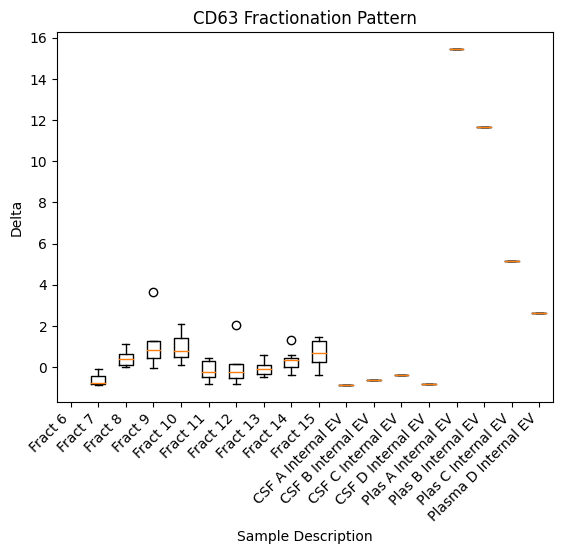

In [6]:
# graph CD63 medians to confirm correct fractionation pattern
cd63 = normalized_data[normalized_data["Assay"] == "CD63"]



cd63["Sample Description"] = pd.Categorical(
    cd63["Sample Description"], categories=X_AXIS_ORDER, ordered=True
)


cd63_sorted = cd63.sort_values("Sample Description")

grouped_data = [
    group["Delta"].values for name, group in cd63_sorted.groupby("Sample Description")
]



plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)


plt.xlabel("Sample Description")


plt.ylabel("Delta")


plt.title("CD63 Fractionation Pattern")


plt.xticks(range(1, len(X_AXIS_ORDER) + 1), X_AXIS_ORDER)


plt.xticks(rotation=45, ha="right")


plt.show()

In [7]:
# TODO: see how many transmembrane/soluble/cytosolic proteins there are in the dataset and make a pie chart

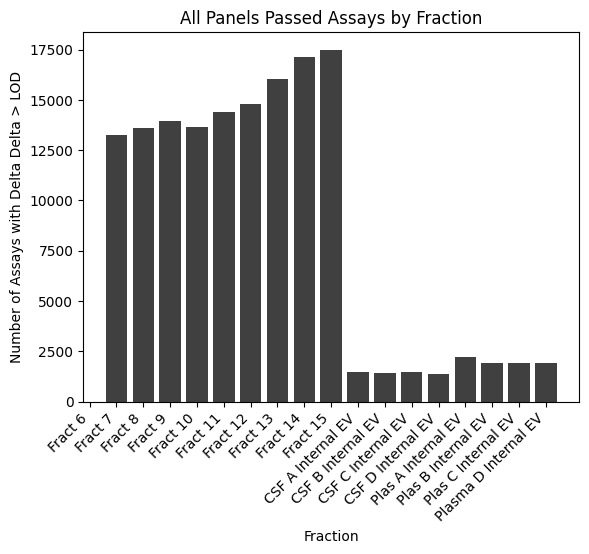

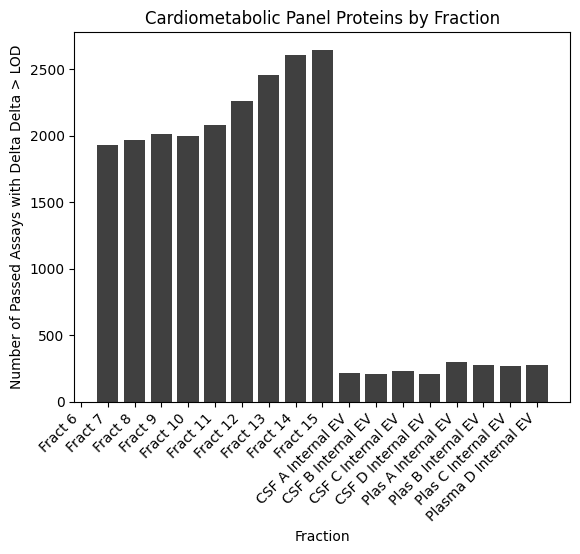

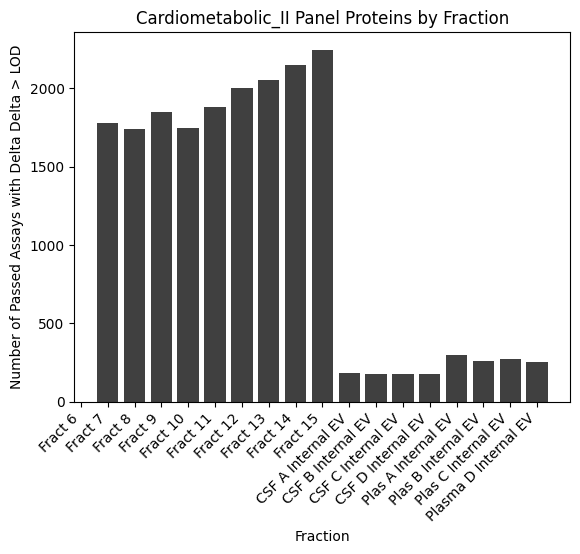

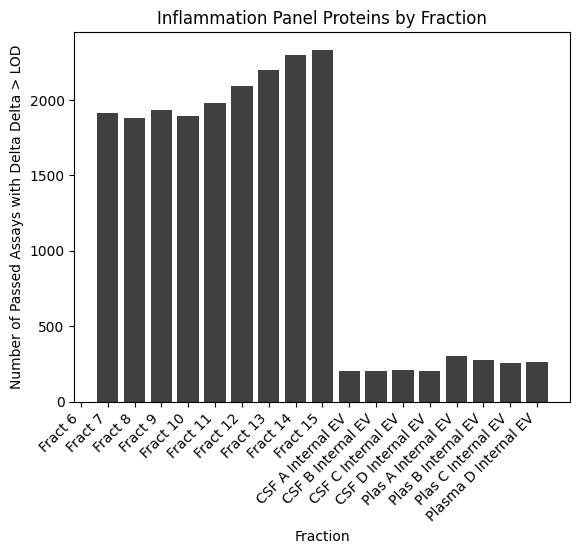

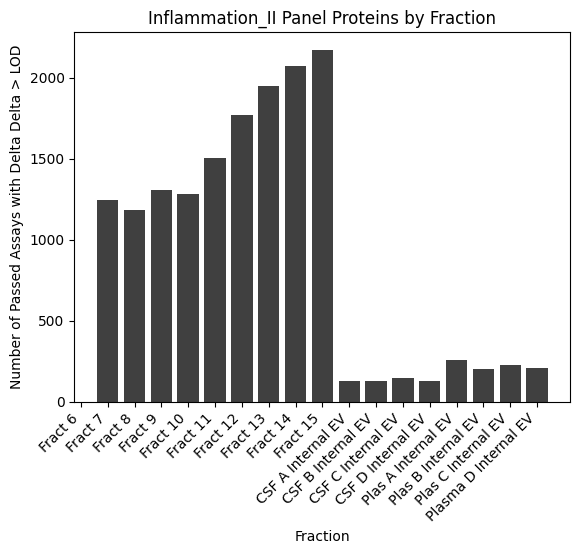

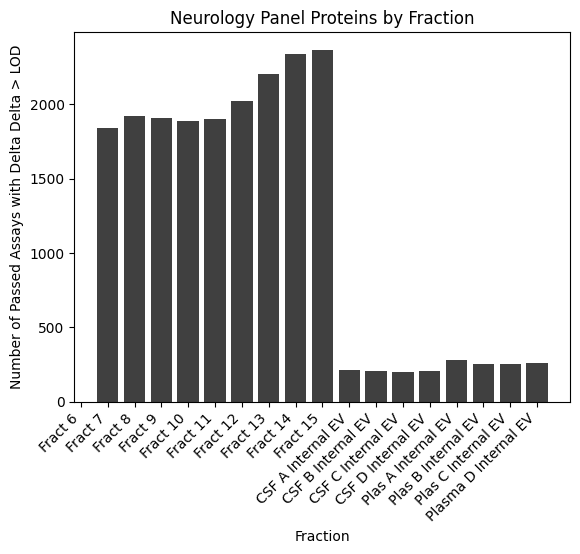

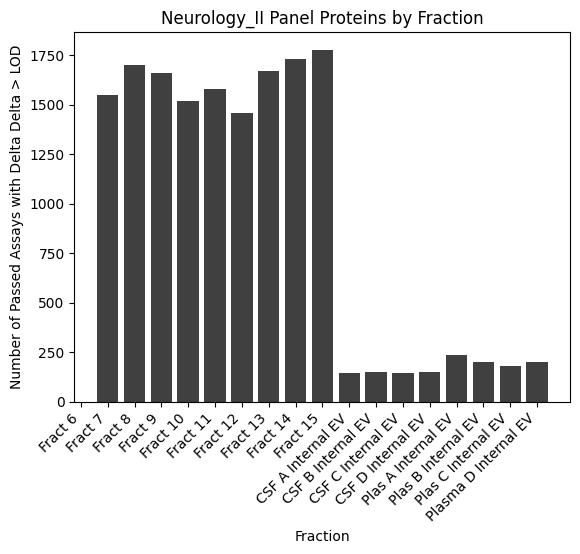

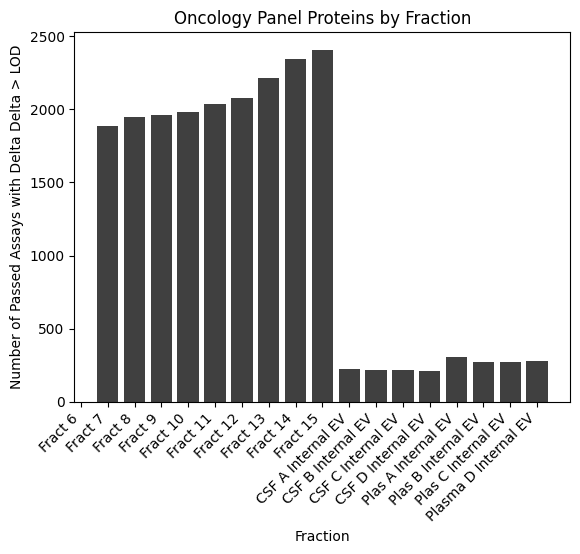

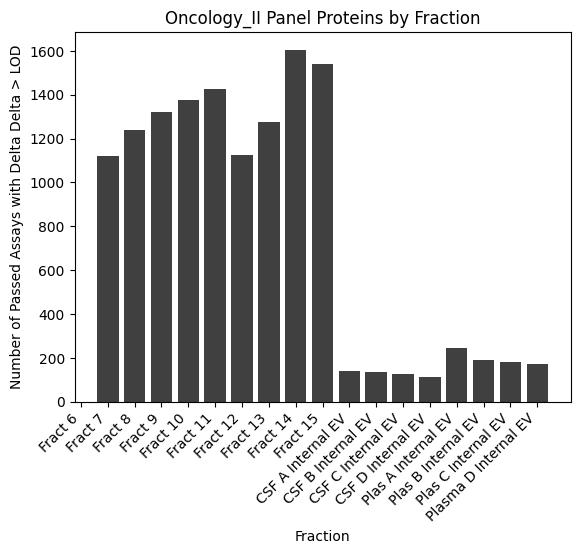

In [8]:
# plot number of normalized NPX values above LOD by panel
filtered_npx = normalized_data[normalized_data["Delta Delta"] > normalized_data["LOD"]]
filtered_npx = filtered_npx[filtered_npx["QC_Warning"] == "PASS"]
filtered_npx = filtered_npx[filtered_npx["Assay_Warning"] == "PASS"]


def plot_by_panel(panel):
    if panel in PANELS:
        npx = filtered_npx[filtered_npx["Panel"] == panel]
        counts = (npx["Sample Description"].value_counts()).reindex(X_AXIS_ORDER)
        plt.bar(counts.index, counts.values, color="k", alpha=0.75)
        plt.xlabel("Fraction")
        plt.ylabel("Number of Passed Assays with Delta Delta > LOD")
        plt.title(f"{panel} Panel Proteins by Fraction")
        plt.xticks(rotation=45, ha="right")
        plt.show()
    else:
        fract_counts = (filtered_npx["Sample Description"].value_counts()).reindex(
            X_AXIS_ORDER
        )
        plt.bar(fract_counts.index, fract_counts.values, color="k", alpha=0.75)
        plt.xlabel("Fraction")
        plt.ylabel("Number of Assays with Delta Delta > LOD")
        plt.title("All Panels Passed Assays by Fraction")
        plt.xticks(rotation=45, ha="right")
        plt.show()


plot_by_panel("all")
for panel in PANELS:
    plot_by_panel(panel)

559
570
441


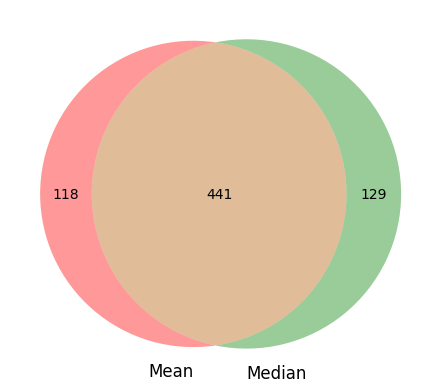

In [9]:
correct_fractionation_mean = []
correct_fractionation_median = []

for assay in assay_list["UniProt ID"].unique():
    subset = normalized_data[normalized_data["UniProt"] == assay]
    late_ev_fractions = subset[
        (
            (subset["Sample Description"].str.contains("Fract 9"))
            | (subset["Sample Description"].str.contains("Fract 10"))
        )
    ]
    all_ev_fractions = subset[
        (
            (subset["Sample Description"].str.contains("Fract 7"))
            | (subset["Sample Description"].str.contains("Fract 8"))
            | (subset["Sample Description"].str.contains("Fract 9"))
            | (subset["Sample Description"].str.contains("Fract 10"))
        )
    ]
    early_soluble_fractions = subset[
        (
            (subset["Sample Description"].str.contains("Fract 11"))
            | (subset["Sample Description"].str.contains("Fract 12"))
        )
    ]
    late_soluble_fractions = subset[
        (
            (subset["Sample Description"].str.contains("Fract 13"))
            | (subset["Sample Description"].str.contains("Fract 14"))
        )
    ]
    if (
        (late_ev_fractions["Delta"].mean() > early_soluble_fractions["Delta"].mean())
        and (all_ev_fractions["Delta"].mean() > late_soluble_fractions["Delta"].mean())
    ) or (
        (all_ev_fractions["Delta"].mean() > early_soluble_fractions["Delta"].mean())
        and (late_ev_fractions["Delta"].mean() > late_soluble_fractions["Delta"].mean())
    ):
        correct_fractionation_mean.append(assay)
    if (
        (
            late_ev_fractions["Delta"].median()
            > early_soluble_fractions["Delta"].median()
        )
        and (
            all_ev_fractions["Delta"].median()
            > late_soluble_fractions["Delta"].median()
        )
    ) or (
        (all_ev_fractions["Delta"].median() > early_soluble_fractions["Delta"].median())
        and (
            late_ev_fractions["Delta"].median()
            > late_soluble_fractions["Delta"].median()
        )
    ):
        correct_fractionation_median.append(assay)

print(len(correct_fractionation_mean))
print(len(correct_fractionation_median))
print(len(set(correct_fractionation_mean) & set(correct_fractionation_median)))

correct_fractionation_mean_set = set(correct_fractionation_mean)
correct_fractionation_median_set = set(correct_fractionation_median)

venn2(
    [correct_fractionation_mean_set, correct_fractionation_median_set],
    set_labels=("Mean", "Median"),
)
plt.show()

In [10]:
# filter the dataframe to only include targets that are 3x enriched in cell type of interest
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)


fetal_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_fetal_1",
    "astrocytes_fetal_2",
    "astrocytes_fetal_3",
    "astrocytes_fetal_4",
    "astrocytes_fetal_5",
    "astrocytes_fetal_6",
]  # should this list be in the first cell at the top of the file? (same question applies for the mature astrocyte, endothelial, microglia, oligodendrocytes lists)
fetal_astrocytes = brain_rna_seq[fetal_astrocytes_cols]


mature_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
mature_astrocytes = brain_rna_seq[mature_astrocytes_cols]

endothelial_cols = ["gene_id", "id", "endothelial_1", "endothelial_2"]
endothelial = brain_rna_seq[endothelial_cols]

microglia_cols = ["gene_id", "id", "microglla_1", "microglla_2", "microglla_3"]
microglia = brain_rna_seq[microglia_cols]

oligodendrocyte_cols = [
    "gene_id",
    "id",
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
oligodendrocytes = brain_rna_seq[oligodendrocyte_cols]

not_median_calc = ["gene_id", "id"]


def find_median(row):
    row_series = pd.Series(row)
    return row_series.median()


oligodendrocyte_values = oligodendrocytes.drop(not_median_calc, axis=1)
oligodendrocyte_values["Median"] = oligodendrocyte_values.apply(find_median, axis=1)
oligodendrocyte_medians = pd.merge(  # this is dependent on the index of the dataframe not changing when it is split, is this a reasonable assumption
    oligodendrocytes,
    oligodendrocyte_values["Median"],
    left_index=True,
    right_index=True,
)

microglia_values = microglia.drop(not_median_calc, axis=1)
microglia_values["Median"] = microglia_values.apply(find_median, axis=1)
microglia_medians = pd.merge(
    microglia, microglia_values["Median"], left_index=True, right_index=True
)

endothelial_values = endothelial.drop(not_median_calc, axis=1)
endothelial_values["Median"] = endothelial_values.apply(find_median, axis=1)
endothelial_medians = pd.merge(
    endothelial, endothelial_values["Median"], left_index=True, right_index=True
)

mature_astrocytes_values = mature_astrocytes.drop(not_median_calc, axis=1)
mature_astrocytes_values["Median"] = mature_astrocytes_values.apply(find_median, axis=1)
mature_astrocytes_medians = pd.merge(
    mature_astrocytes,
    mature_astrocytes_values["Median"],
    left_index=True,
    right_index=True,
)

fetal_astrocytes_values = fetal_astrocytes.drop(not_median_calc, axis=1)
fetal_astrocytes_values["Median"] = fetal_astrocytes_values.apply(find_median, axis=1)
fetal_astrocytes_medians = pd.merge(
    fetal_astrocytes,
    fetal_astrocytes_values["Median"],
    left_index=True,
    right_index=True,
)

# filter the dataframes to only include proteins where microglia expression is 3x greater than other cell type expression
microglia_targets = microglia_medians[
    (microglia_medians["Median"] > (3 * oligodendrocyte_medians["Median"]))
    & (microglia_medians["Median"] > (3 * endothelial_medians["Median"]))
    & (microglia_medians["Median"] > (3 * mature_astrocytes_medians["Median"]))
    & (microglia_medians["Median"] > (3 * fetal_astrocytes_medians["Median"]))
]

microglia_targets[["Gene", "Species"]] = microglia_targets["gene_id"].str.split(
    " - ", expand=True
)

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_26356\4136116299.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microglia_targets[["Gene", "Species"]] = microglia_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_26356\4136116299.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microglia_targets[["Gene", "Species"]] = microglia_targets["gene_id"].str.split(


In [11]:
# map the hgnc id's to the uniprot id's

response = requests.get(HGNC_IDS)
content = response.text

file_like_object = StringIO(content)

uniprot_ids = pd.read_csv(file_like_object, sep="\t")

microglia_targets = pd.merge(
    microglia_targets,
    uniprot_ids[["hgnc_id", "uniprot_ids"]],
    left_on="id",
    right_on="hgnc_id",
    how="left",
)

microglia_targets = microglia_targets[
    microglia_targets["uniprot_ids"].isin(correct_fractionation_median)
]

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_26356\1929329259.py:8: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  uniprot_ids = pd.read_csv(file_like_object, sep="\t")


In [12]:
# map uniprot id's to fasta
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""

    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()

            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence

    return protein_dict


protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)

microglia_targets["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)

microglia_targets = microglia_targets.drop(
    [
        "id",
        "gene_id",
        "microglla_1",
        "microglla_2",
        "microglla_3",
        "Median",
        "Gene",
        "Species",
        "hgnc_id",
    ],
    axis=1,
)

# export the list of proteins in fasta format to be input into the online program
# link to program: https://dtu.biolib.com/DeepTMHMM
with open(MICROGLIA_FASTA_OUTPUT_PATH, "w") as output_file:
    for index, row in microglia_targets.iterrows():
        output_file.write(f'>{row["uniprot_ids"]}\n')
        output_file.write(f'{row["Sequence"]}\n')

In [13]:
output_directory = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm4_microglia"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

os.chdir(output_directory)

deeptmhmm = biolib.load('DTU/DeepTMHMM')

for _, row in microglia_targets.iterrows(): # there has got to be a way to make this faster this is insanely slow
    sequence = row["Sequence"]
    uniprot_id = row["uniprot_ids"]
    !echo -e f">{uniprot_id}\n{sequence}\n" > query.fasta
    deeptmhmm_job = deeptmhmm.cli(args='--fasta query.fasta')
    deeptmhmm_job.save_files(output_directory)
    # Image(filename='result/plot.png') # I think I'm not accessing the Image package correctly because it doesn't make a difference whether this line is commented out or not, but this also isn't super necessary if the .png file is being correctly uploaded to the results directory
#is there a way to import all the files from the directory for bulk analysis?
# I think with each iteration of the loop it's incorrectly trying to change the name of the output file to add to the directory, making an inaccessible output file
# program (should) output an image of the plot (.png), and gff3/3line/md/csv files

2023-11-28 18:05:28,760 | INFO : Loaded project DTU/DeepTMHMM:1.0.24


HttpError: 400 Error:  for url: https://biolib.com/api/jobs/create_job_with_data/

In [ ]:
# TODO: re-write the program to be run in the opposite order to make sure the output is the same (do transmembrane, then brain rna seq, and then fractionation pattern instead of the other way around)